In [1]:
import pandas as pd
import numpy as np
import os 
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from copy import deepcopy

base_path = '/Users/freezylex/Documents/course_work/'

In [2]:
bid_ask = pd.read_excel('/Users/freezylex/Documents/course_work/not_valid/Metrics and target OLD/All metrics in one folder/bid_ask_spread.xlsx', index_col = 'Date', parse_dates = True)
trad_count = pd.read_excel('/Users/freezylex/Documents/course_work/not_valid/Metrics and target OLD/All metrics in one folder/trades_count.xlsx', index_col = 'Date', parse_dates = True)
price_disp = pd.read_excel('/Users/freezylex/Documents/course_work/not_valid/Metrics and target OLD/All metrics in one folder/price_dispersion.xlsx', index_col = 'Date', parse_dates = True)

In [3]:
(price_disp == 0).sum()

SU26214RMFS    26
SU26215RMFS     1
SU26216RMFS    26
SU26203RMFS     1
SU26204RMFS     0
SU26205RMFS     7
SU26206RMFS     0
SU26207RMFS     0
SU26208RMFS     8
SU26209RMFS    28
SU26210RMFS    36
SU26211RMFS    34
SU26212RMFS     1
dtype: int64

In [4]:
col_order = ['SU26203RMFS', 'SU26206RMFS', 'SU26204RMFS', 'SU26208RMFS',
       'SU26216RMFS', 'SU26210RMFS', 'SU26214RMFS', 'SU26205RMFS',
       'SU26209RMFS', 'SU26211RMFS', 'SU26215RMFS', 'SU26207RMFS',
       'SU26212RMFS']
price_disp.describe()[col_order].to_excel(os.path.join(base_path, 'stats/PD_before.xlsx'))

# Price Dispersion

In [4]:
def make_boxplots(df):
    fig, ax = plt.subplots(2, 7, figsize=(40, 30))
    min_ = df.values.ravel().min()
    max_ = df.values.ravel().max()
    i = 0
    for col in df.columns:
        if i < 7:
            sns.boxplot(y = df[col], ax = ax[0, i])
            ax[0, i].set_ylim([min_ - 0.1, max_ + 0.1])
            ax[0, i].set_ylabel(f'OFZ {col[2:-4]}', fontsize=18)
        else:
            sns.boxplot(y = df[col], ax = ax[1, i-7])
            ax[1, i-7].set_ylim([min_ - 0.1, max_ + 0.1])
            ax[1, i-7].set_ylabel(f'OFZ {col[2:-4]}', fontsize=18)
        i += 1
    #plt.savefig(os.path.join(base_path, 'graphs/PD_before.png'), dpi=300)

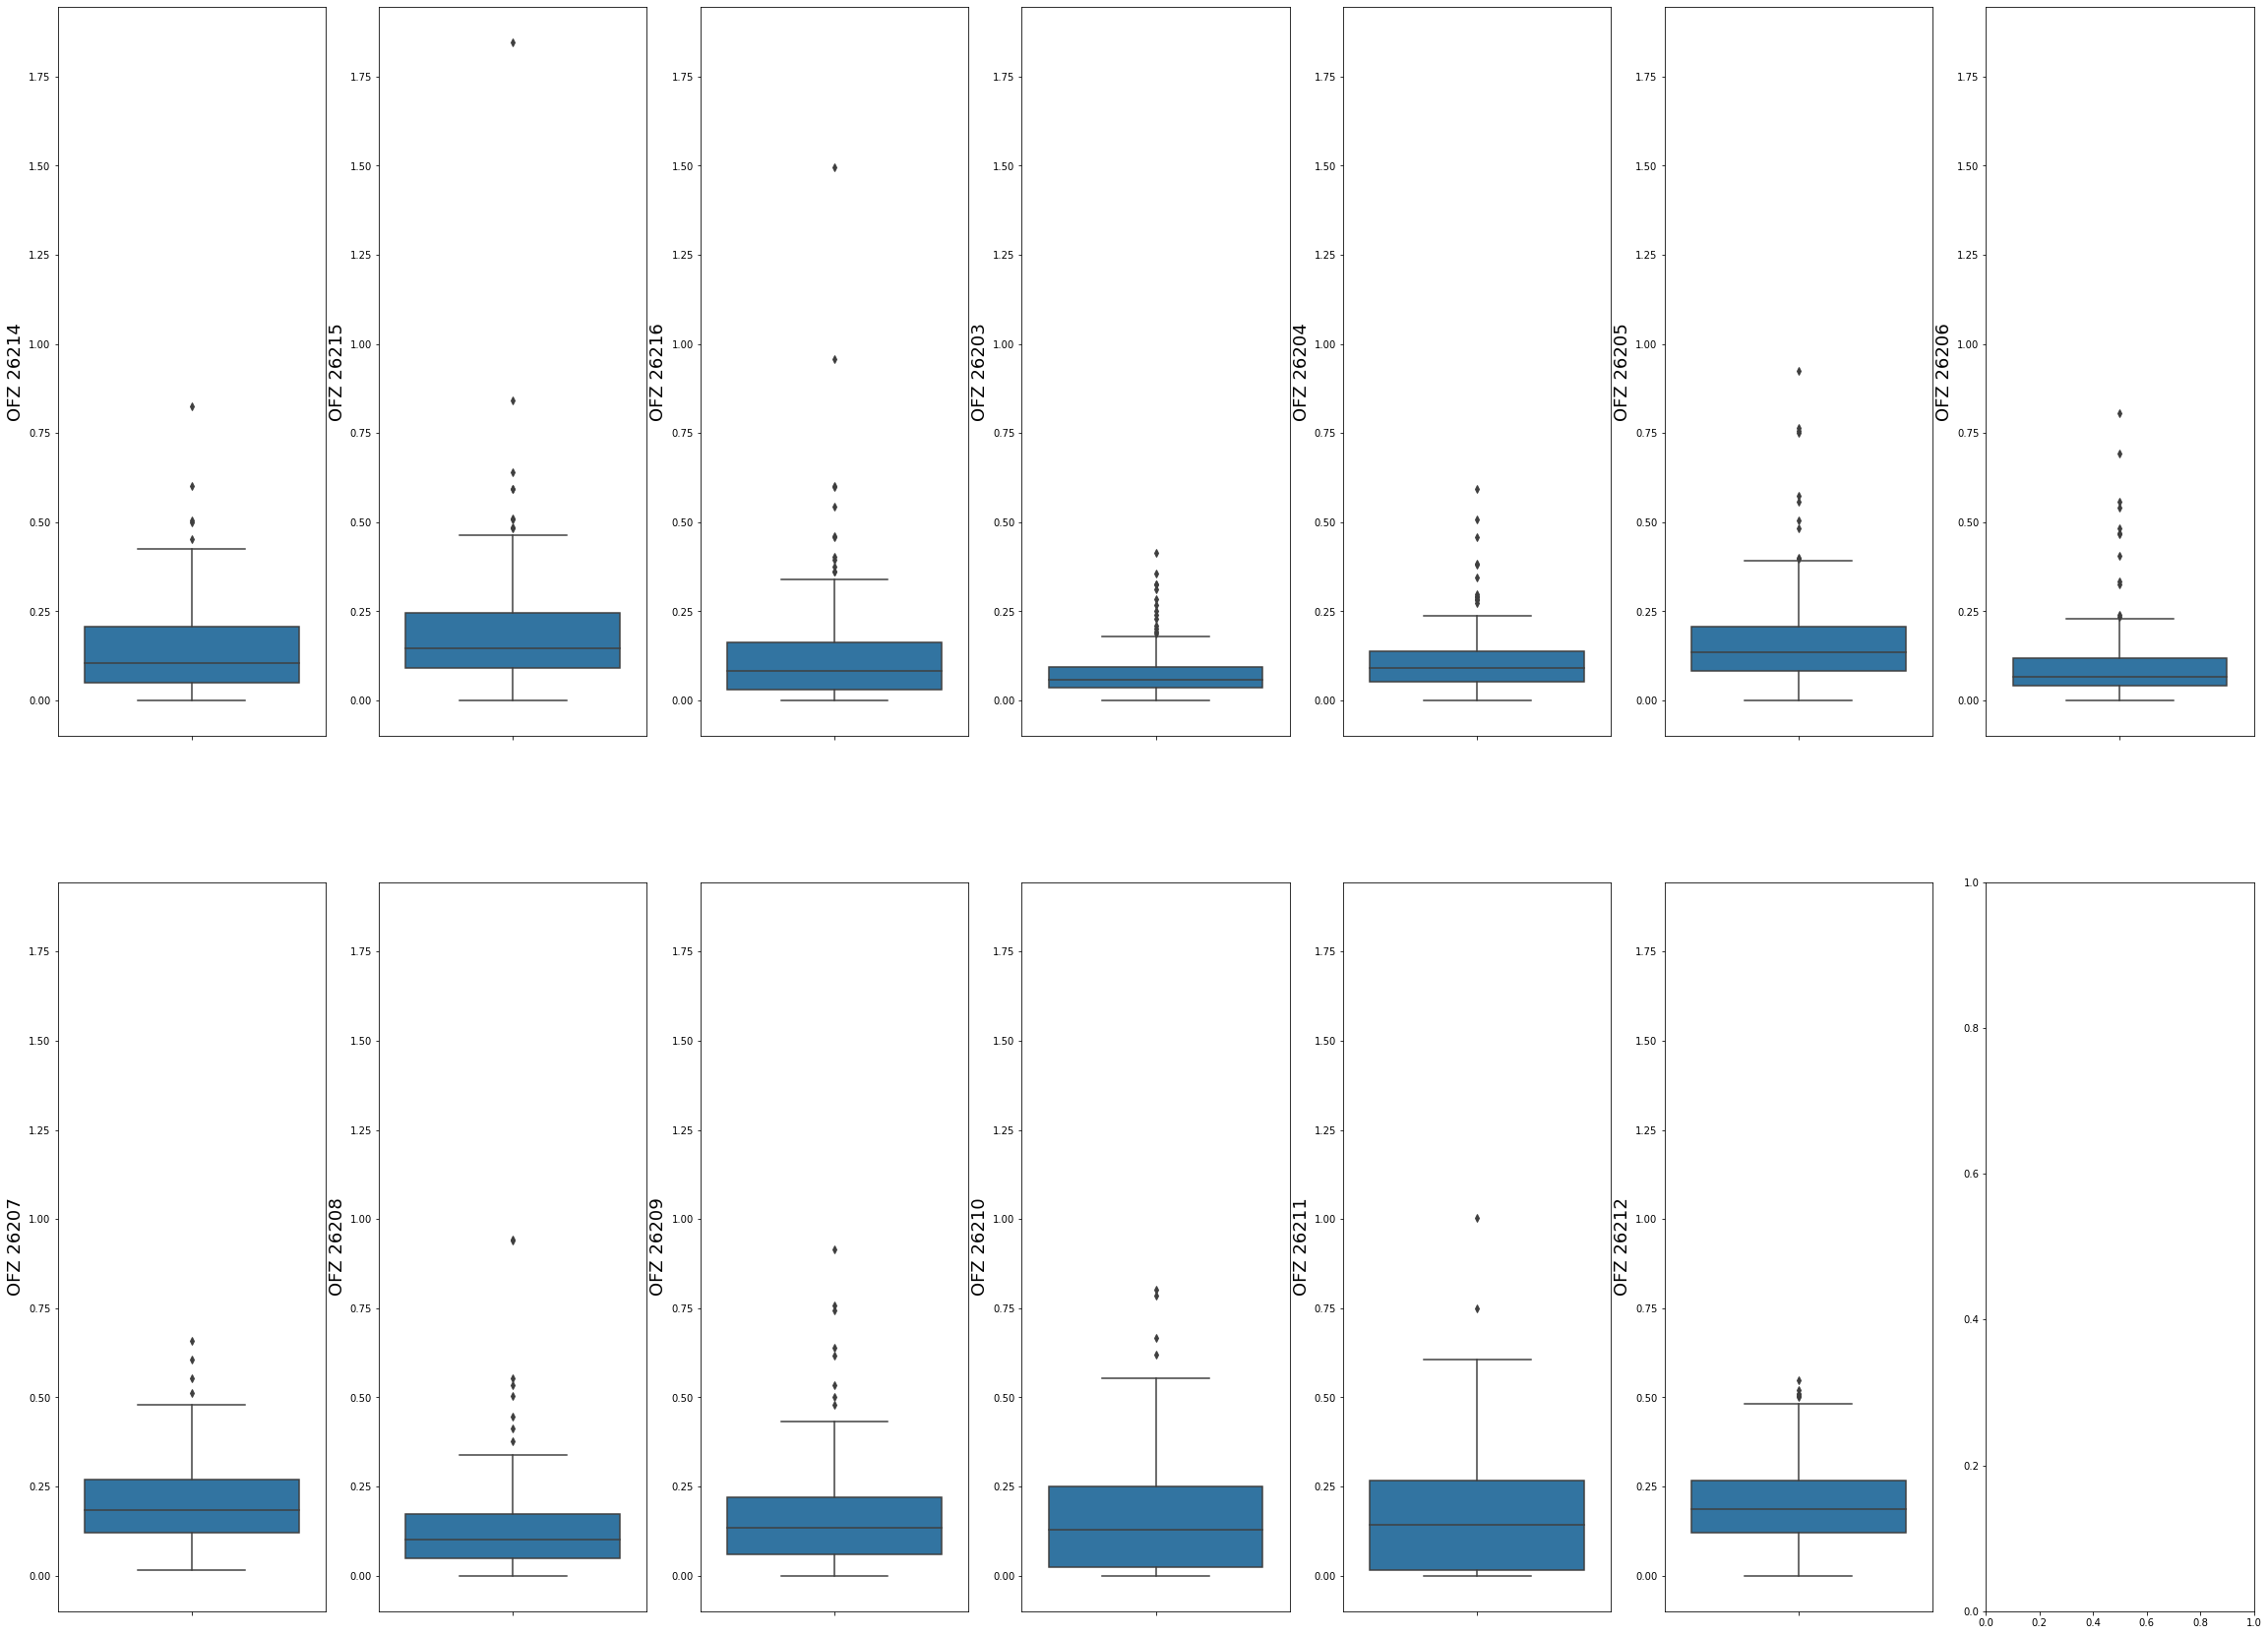

In [8]:
make_boxplots(price_disp)

In [6]:
class PD_filling:
    def __init__(self, X):
        self.quant_99 = {}
        self.train = deepcopy(X.loc[:'2016-01'])
        self.test = deepcopy(X.loc['2016-02':])
        
    def fit_zero_days(self):
        self.cols = self.train.columns
        for col in self.cols:
            vals = self.train[col].values
            q_99 = np.quantile(vals, q=0.99)
            self.quant_99[col] = q_99
            self.train.loc[self.train[col] == 0, col] = q_99
        return self
    
    def transform_to_log(self):
        self.train = np.log(self.train)
        self.test = np.log(self.test)
        self.X = pd.concat([self.train, self.test])
        return self.X

In [7]:
pdfill = PD_filling(price_disp)
pdfill.fit_zero_days()
new_pd = pdfill.transform_to_log()

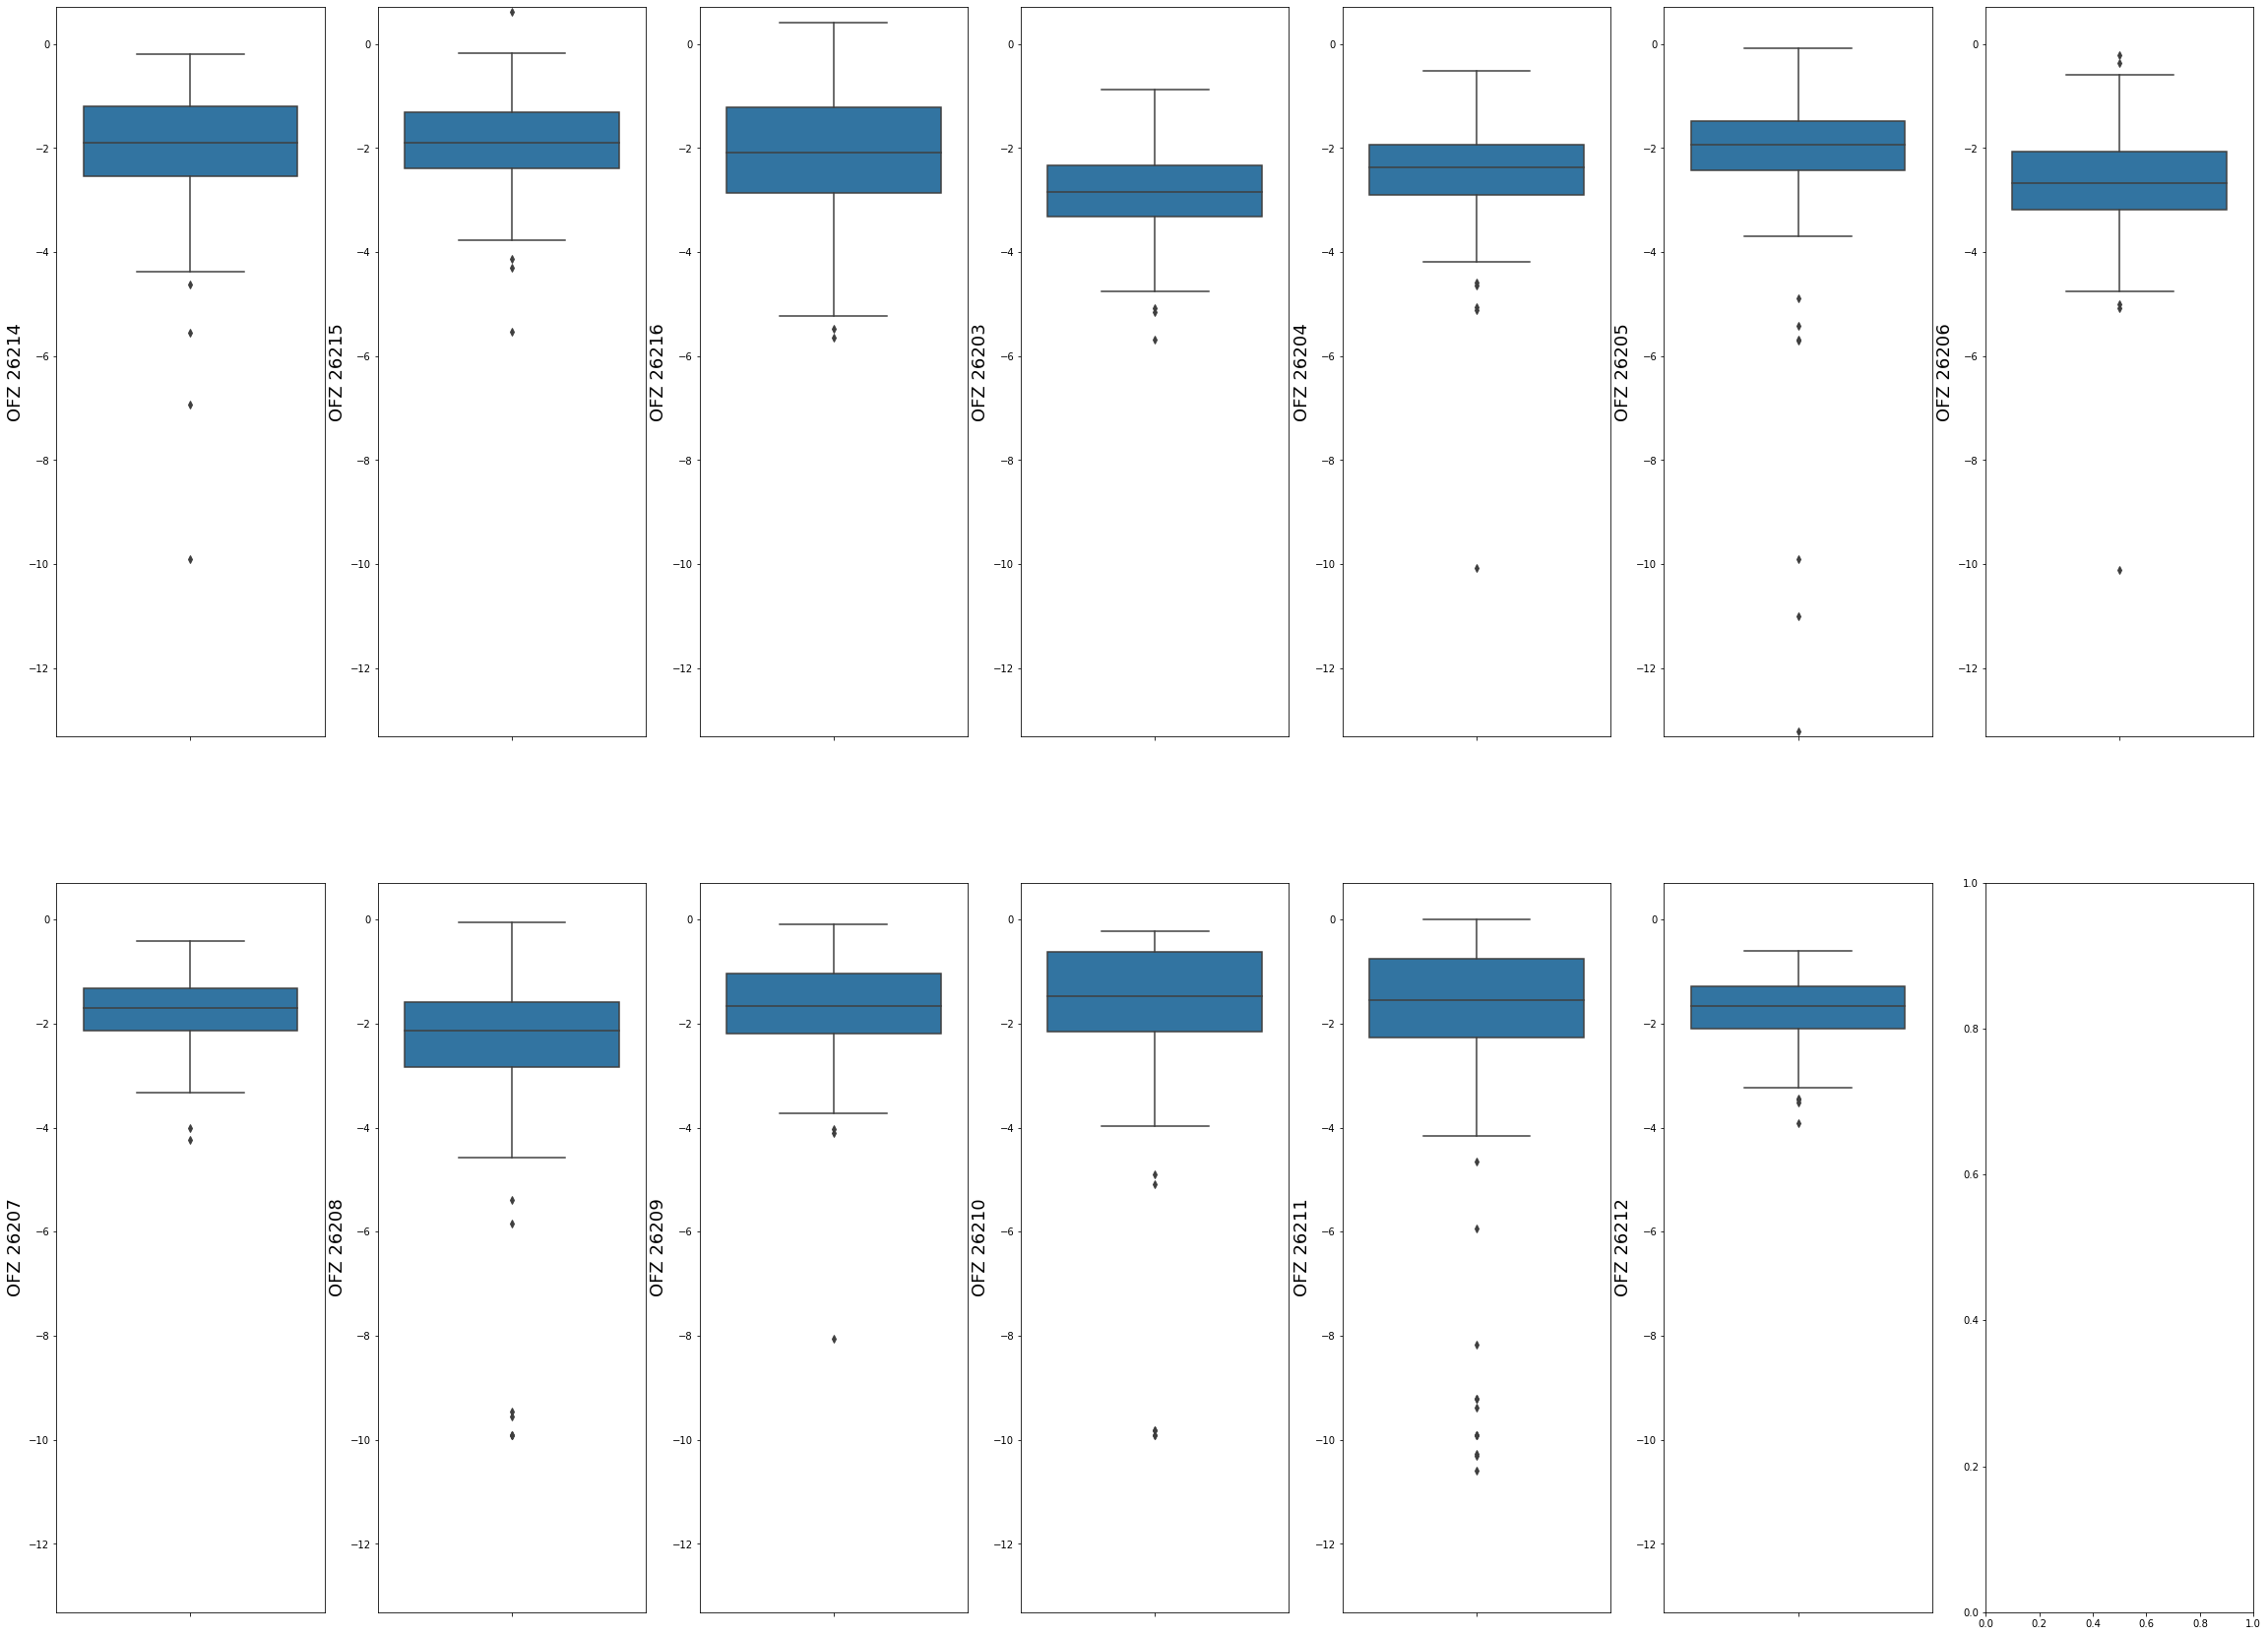

In [11]:
make_boxplots(new_pd.loc[:'2016-01'])

In [8]:
class mark_low_trading_days:
    
    def __init__(self, X):
        self.train = deepcopy(X.loc[:'2016-01'])
        self.test = deepcopy(X.loc['2016-02':])
        self.low_vals = {}
    
    def fit_transform(self, q):
        for bond in self.train.columns:
            vals = self.train[bond].values
            q_ = np.quantile(vals, q = q)
            self.low_vals[bond] = q_
        
        for col in self.train.columns:
            self.train[col + '_low_trading_dummy'] = 0
            self.train.loc[self.train[col] < self.low_vals[col], col + '_low_trading_dummy'] = 1
        for col in self.test.columns:
            self.test[col + '_low_trading_dummy'] = 0
            self.test.loc[self.test[col] < self.low_vals[col], col + '_low_trading_dummy'] = 1
            
        return pd.concat([self.train, self.test])
    

In [9]:
lpd = mark_low_trading_days(new_pd)
pd_final = lpd.fit_transform(0.02)
pd_final.head(2)

,SU26214RMFS,SU26215RMFS,SU26216RMFS,SU26203RMFS,SU26204RMFS,SU26205RMFS,SU26206RMFS,SU26207RMFS,SU26208RMFS,SU26209RMFS,...,SU26203RMFS_low_trading_dummy,SU26204RMFS_low_trading_dummy,SU26205RMFS_low_trading_dummy,SU26206RMFS_low_trading_dummy,SU26207RMFS_low_trading_dummy,SU26208RMFS_low_trading_dummy,SU26209RMFS_low_trading_dummy,SU26210RMFS_low_trading_dummy,SU26211RMFS_low_trading_dummy,SU26212RMFS_low_trading_dummy
Date,,,,,,,,,,,,,,,,,,,,,
2015-06-01,-0.625084,-3.218626,-0.980829,-3.316853,-1.677696,-1.89712,-1.566845,-4.008730,-1.733126,-0.980963,...,0,0,0,0,1,0,0,0,0,0
2015-06-02,-0.793177,-0.522765,-1.014178,-3.652116,-2.198555,-0.98992,-10.108318,-1.997904,-1.149333,-0.089743,...,0,0,0,1,0,0,0,0,0,0


In [10]:
pd_final.sum()[13:]

SU26214RMFS_low_trading_dummy    5.0
SU26215RMFS_low_trading_dummy    4.0
SU26216RMFS_low_trading_dummy    5.0
SU26203RMFS_low_trading_dummy    4.0
SU26204RMFS_low_trading_dummy    4.0
SU26205RMFS_low_trading_dummy    4.0
SU26206RMFS_low_trading_dummy    4.0
SU26207RMFS_low_trading_dummy    4.0
SU26208RMFS_low_trading_dummy    4.0
SU26209RMFS_low_trading_dummy    5.0
SU26210RMFS_low_trading_dummy    4.0
SU26211RMFS_low_trading_dummy    3.0
SU26212RMFS_low_trading_dummy    4.0
dtype: float64

### Target

In [11]:
rates = pd.read_excel(base_path + '/data/final_target.xlsx',
                      index_col = 'Date', parse_dates=True)
rates = rates.loc['2015-06-01':]
rates = rates[price_disp.columns]
rates.head(2)

,SU26214RMFS,SU26215RMFS,SU26216RMFS,SU26203RMFS,SU26204RMFS,SU26205RMFS,SU26206RMFS,SU26207RMFS,SU26208RMFS,SU26209RMFS,SU26210RMFS,SU26211RMFS,SU26212RMFS
Date,,,,,,,,,,,,,
2015-06-01,75.435653,70.497373,86.023206,229.412964,118.050520,72.106594,157.825200,78.732393,89.805183,70.380384,78.827604,70.260055,82.340604
2015-06-02,79.195092,75.613379,88.217705,233.133964,119.526222,76.913298,159.942505,82.903762,91.735789,75.711110,81.883053,75.535258,86.478395


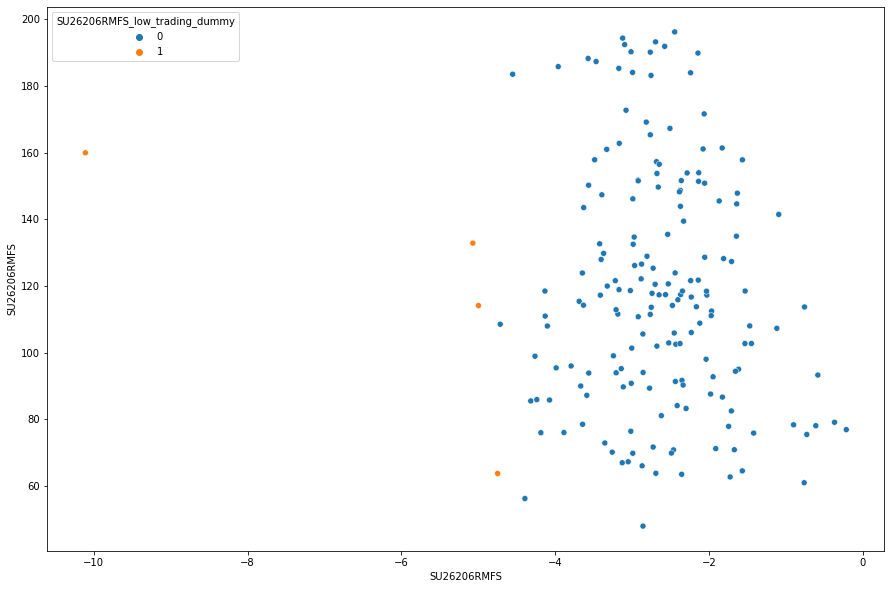

In [15]:
bond = 'SU26206RMFS'

fig, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(x = pd_final[bond], y = rates[bond], hue = pd_final[bond +'_low_trading_dummy'])
plt.show()

In [15]:
pd_final.to_csv(os.path.join(base_path, 'data/metrics_final/PD.csv'))

In [16]:
pd_final.describe()[col_order].to_excel(os.path.join(base_path, 'stats/PD_after.xlsx'))

Text(0.5, 1.0, 'Logarithm of Price dispersion dynamics for all bonds, rolling mean with window = 15')

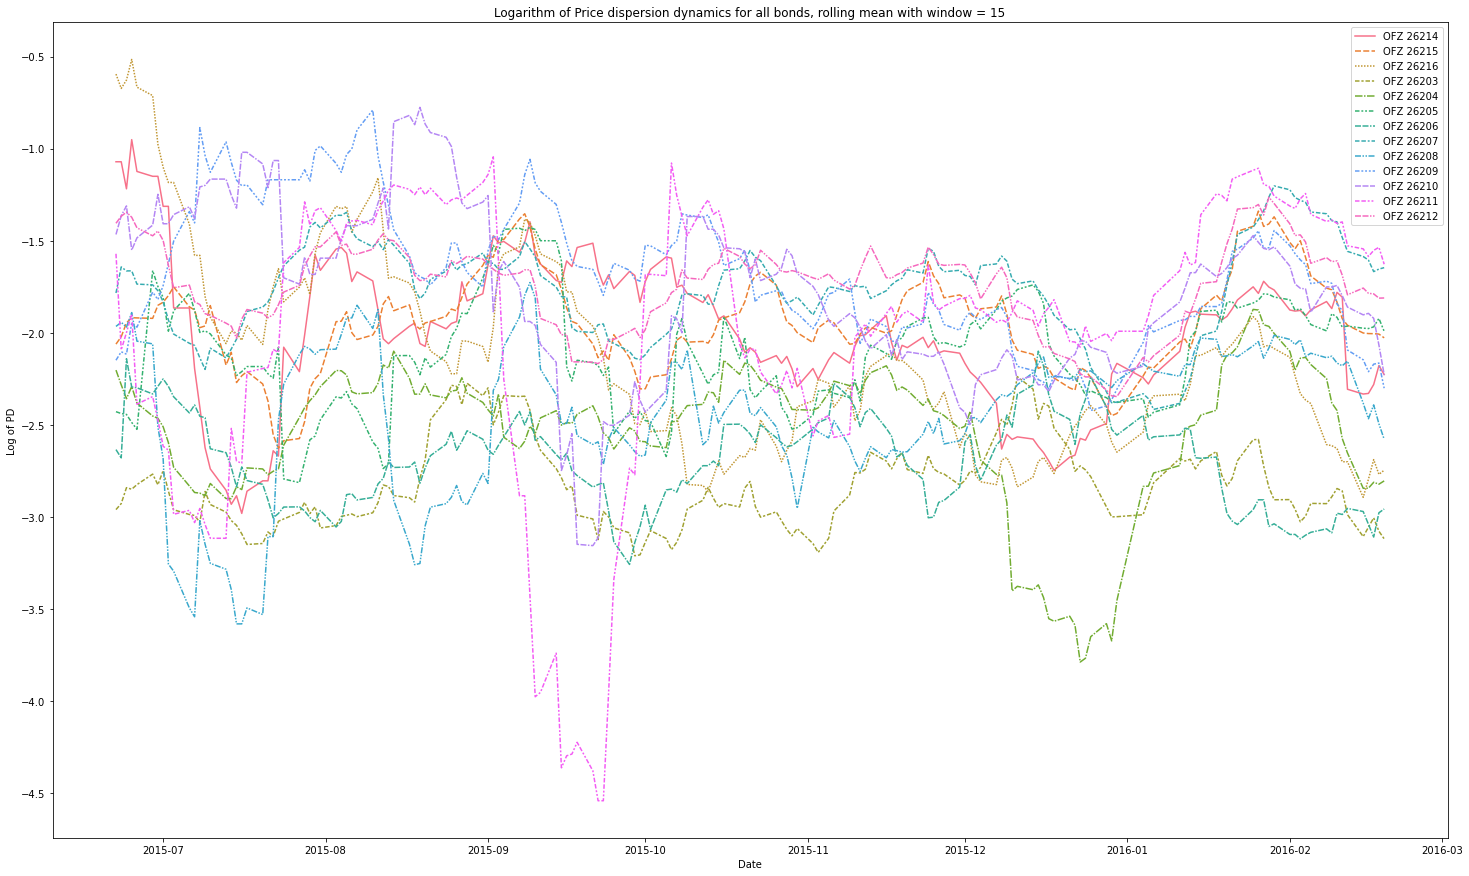

In [17]:
pd_final = pd_final[pd_final.columns[:13]]
pd_final.columns =  ['OFZ ' + x[2:-4] for x in pd_final.columns]
fig, ax = plt.subplots(figsize=(25, 15))
sns.lineplot(data = pd_final.rolling(window=15).mean())
plt.ylabel('Log of PD')
plt.title('Logarithm of Price dispersion dynamics for all bonds, rolling mean with window = 15')
#plt.savefig(os.path.join(base_path, 'graphs/log_TC_dynamics.png'), dpi=300)

# Trade count

In [16]:
(trad_count == 0).sum()

SU26214RMFS    13
SU26215RMFS     0
SU26216RMFS    13
SU26203RMFS     0
SU26204RMFS     0
SU26205RMFS     2
SU26206RMFS     0
SU26207RMFS     0
SU26208RMFS     1
SU26209RMFS    12
SU26210RMFS    15
SU26211RMFS    15
SU26212RMFS     1
dtype: int64

In [19]:
trad_count.describe()[col_order].to_excel(os.path.join(base_path, 'stats/TC_before.xlsx'))

In [12]:
trad_count +=1
trad_count = np.log(trad_count)

In [21]:
trad_count.describe()[col_order].to_excel(os.path.join(base_path, 'stats/TC_after.xlsx'))

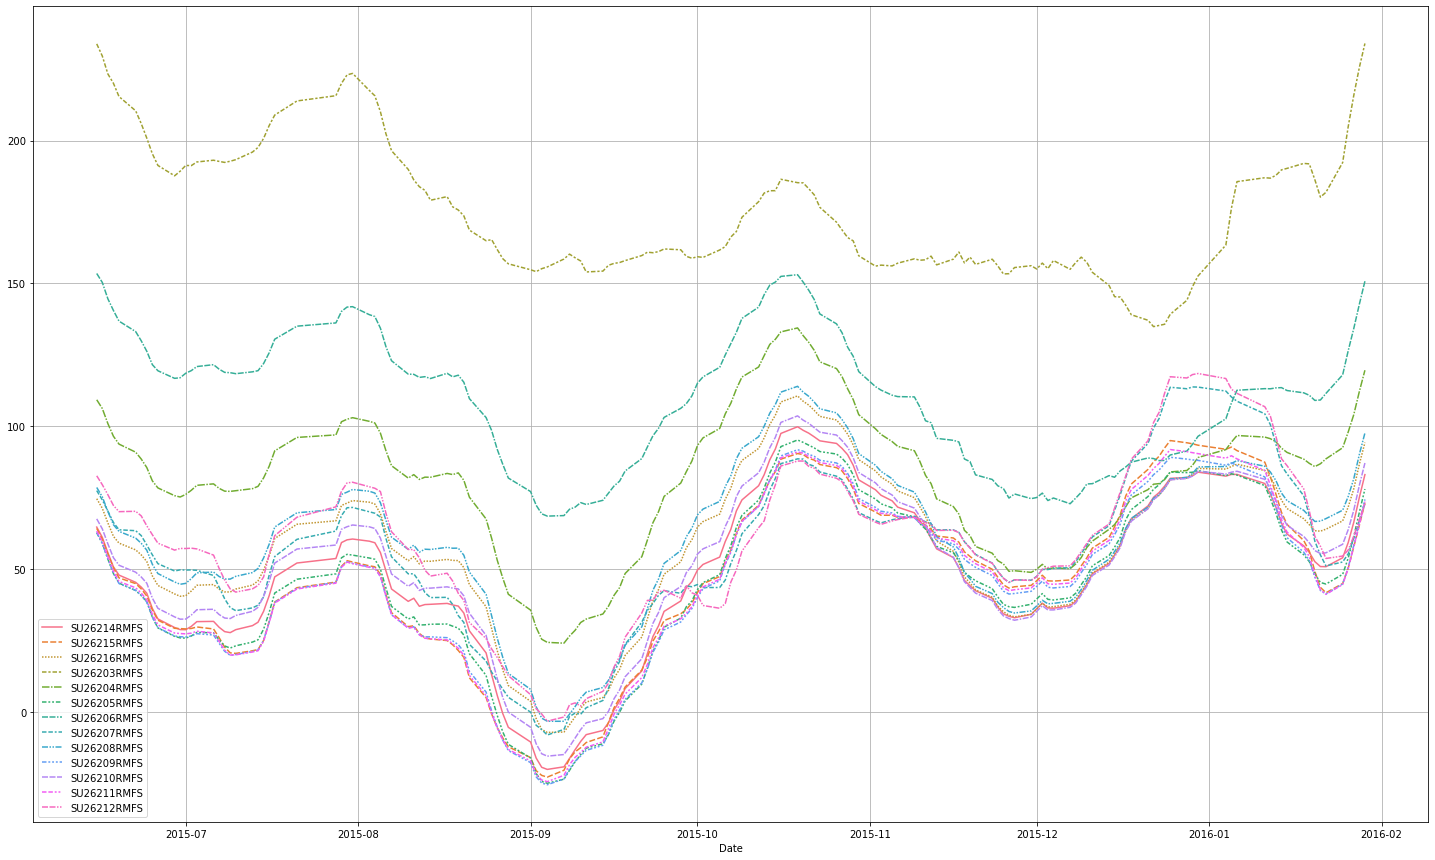

In [22]:
fig, ax = plt.subplots(figsize=(25, 15))
sns.lineplot(data = rates.loc[:'2016-01'].rolling(window=10).mean())
plt.grid()
plt.show()

In [13]:
tc = mark_low_trading_days(trad_count)
tc_final = tc.fit_transform(0.02)
tc_final.head(2)

,SU26214RMFS,SU26215RMFS,SU26216RMFS,SU26203RMFS,SU26204RMFS,SU26205RMFS,SU26206RMFS,SU26207RMFS,SU26208RMFS,SU26209RMFS,...,SU26203RMFS_low_trading_dummy,SU26204RMFS_low_trading_dummy,SU26205RMFS_low_trading_dummy,SU26206RMFS_low_trading_dummy,SU26207RMFS_low_trading_dummy,SU26208RMFS_low_trading_dummy,SU26209RMFS_low_trading_dummy,SU26210RMFS_low_trading_dummy,SU26211RMFS_low_trading_dummy,SU26212RMFS_low_trading_dummy
Date,,,,,,,,,,,,,,,,,,,,,
2015-06-01,0.693147,1.791759,1.098612,2.397895,2.772589,1.098612,2.772589,3.465736,1.386294,1.098612,...,0,0,0,0,0,0,0,0,0,1
2015-06-02,2.708050,2.079442,2.397895,3.465736,1.609438,2.772589,1.945910,3.828641,2.484907,2.944439,...,0,0,0,0,0,0,0,0,0,0


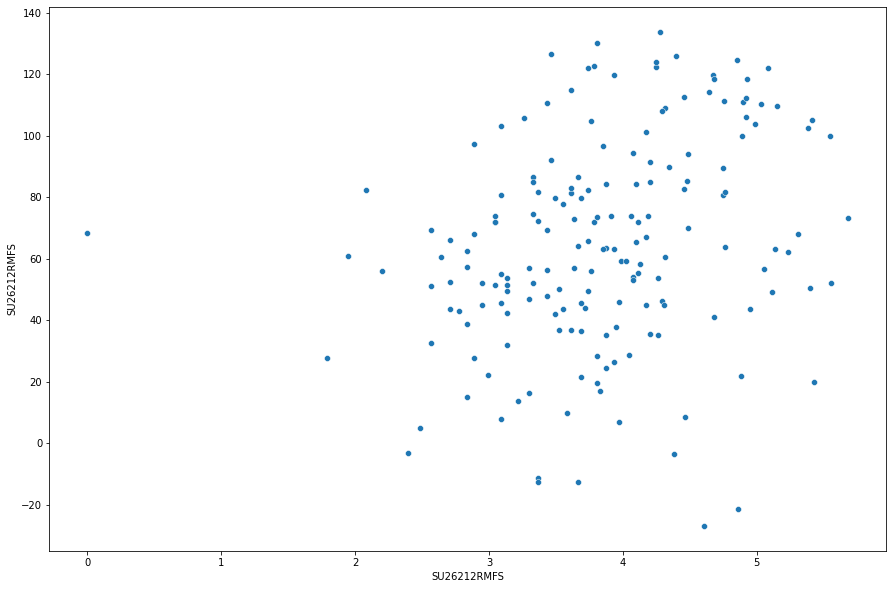

In [19]:
bond = 'SU26212RMFS'

fig, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(x = tc_final[bond], y = rates[bond])
plt.show()

In [21]:
def make_plot_for_TC(df, factor, hue_date=None):
    fig, ax = plt.subplots(1, 3, figsize=(30, 10))
    min_ = df.values.ravel().min()
    max_ = df.values.ravel().max()
    if hue_date:
        h = pd.Series(index = factor.index, data = np.zeros(shape=factor.shape[0]))
        h.loc[hue_date:] = 1
        print(h)
    else:
        h = None
    i = 0
    for col in ['SU26203RMFS', 'SU26214RMFS', 'SU26207RMFS']:
        sns.scatterplot(x = factor[col],y = df[col], ax = ax[i], hue = h, palette='deep')
        ax[i].set_ylim([min_ - 0.1, max_ + 0.1])
        ax[i].set_xlabel('Logarithm of TC', fontsize=15)
        ax[i].set_ylabel(f'OFZ {col[2:-4]}', fontsize=15)
        ax[i].tick_params(axis='both', labelsize=15)
        ax[i].legend(prop=dict(size=18))
        i += 1
    plt.savefig(os.path.join(base_path, 'graphs/log_TC_scatter.png'),dpi=300)

Date
2015-06-01    0.0
2015-06-02    0.0
2015-06-03    0.0
2015-06-04    0.0
2015-06-05    0.0
             ... 
2016-02-15    1.0
2016-02-16    1.0
2016-02-17    1.0
2016-02-18    1.0
2016-02-19    1.0
Length: 184, dtype: float64


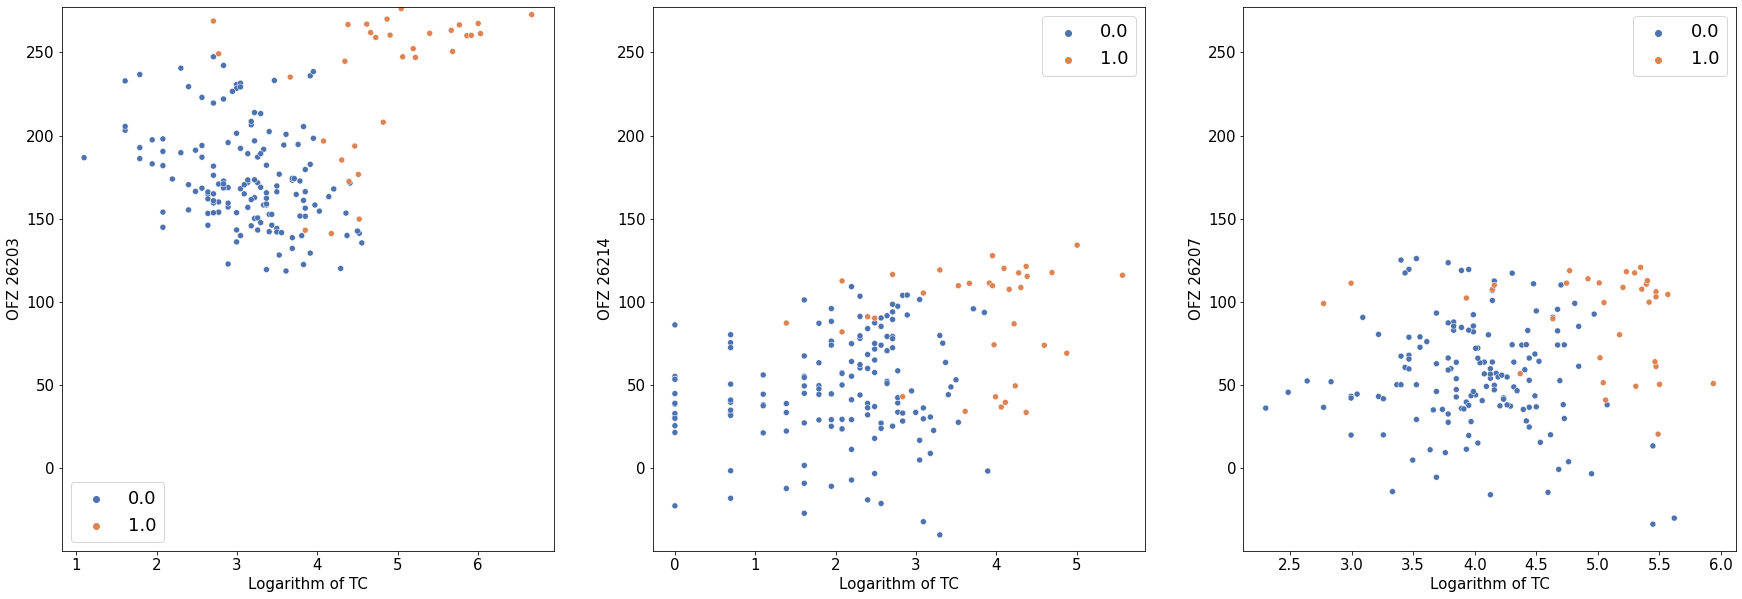

In [23]:
make_plot_for_TC(rates, tc_final, '2016-01-04')

In [25]:
tc_final.to_csv(os.path.join(base_path, 'data/metrics_final/TC.csv'))

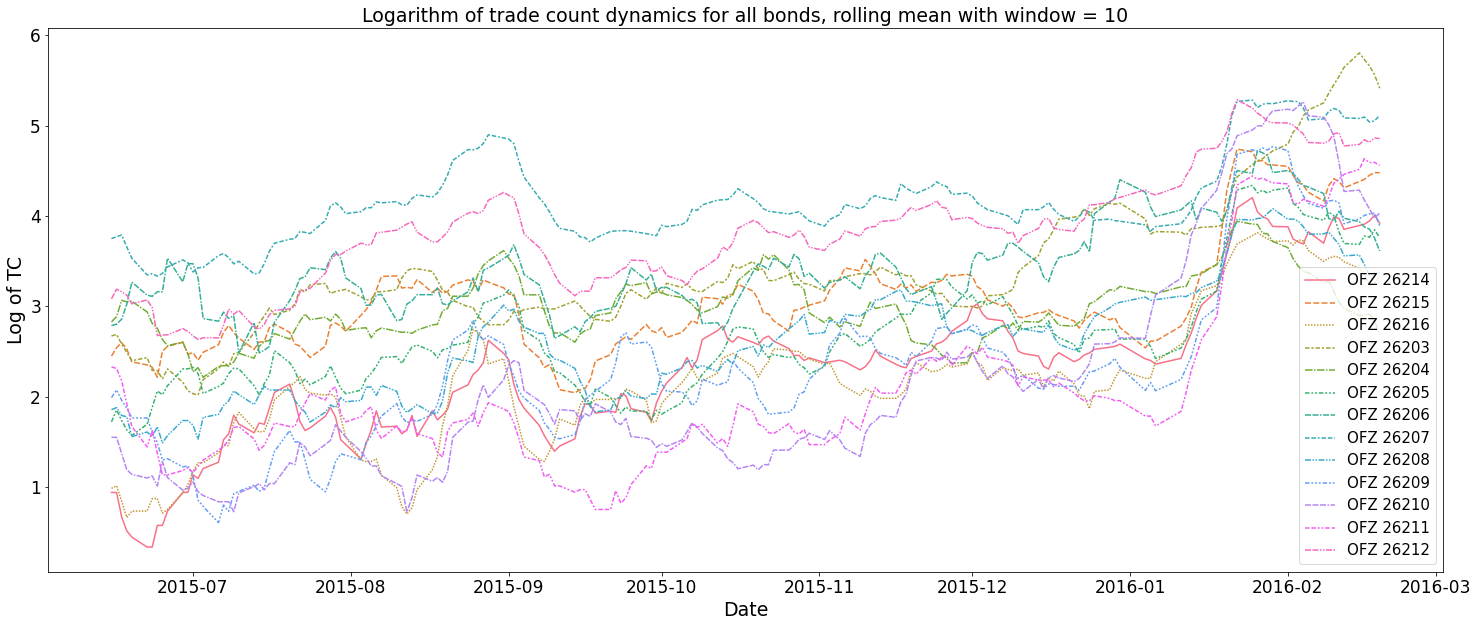

In [15]:
trad_count.columns =  ['OFZ ' + x[2:-4] for x in trad_count.columns]
fig, ax = plt.subplots(figsize=(25, 10))
sns.lineplot(data = trad_count.rolling(window=10).mean())
plt.ylabel('Log of TC', fontsize=19)
plt.title('Logarithm of trade count dynamics for all bonds, rolling mean with window = 10', fontsize=19)
plt.xlabel('Date', fontsize=19)
ax.tick_params(axis='both', which='major', labelsize=17)
plt.legend(fontsize=15, title_fontsize=15)
plt.savefig(os.path.join(base_path, 'graphs/log_TC_dynamics.png'), dpi=300)

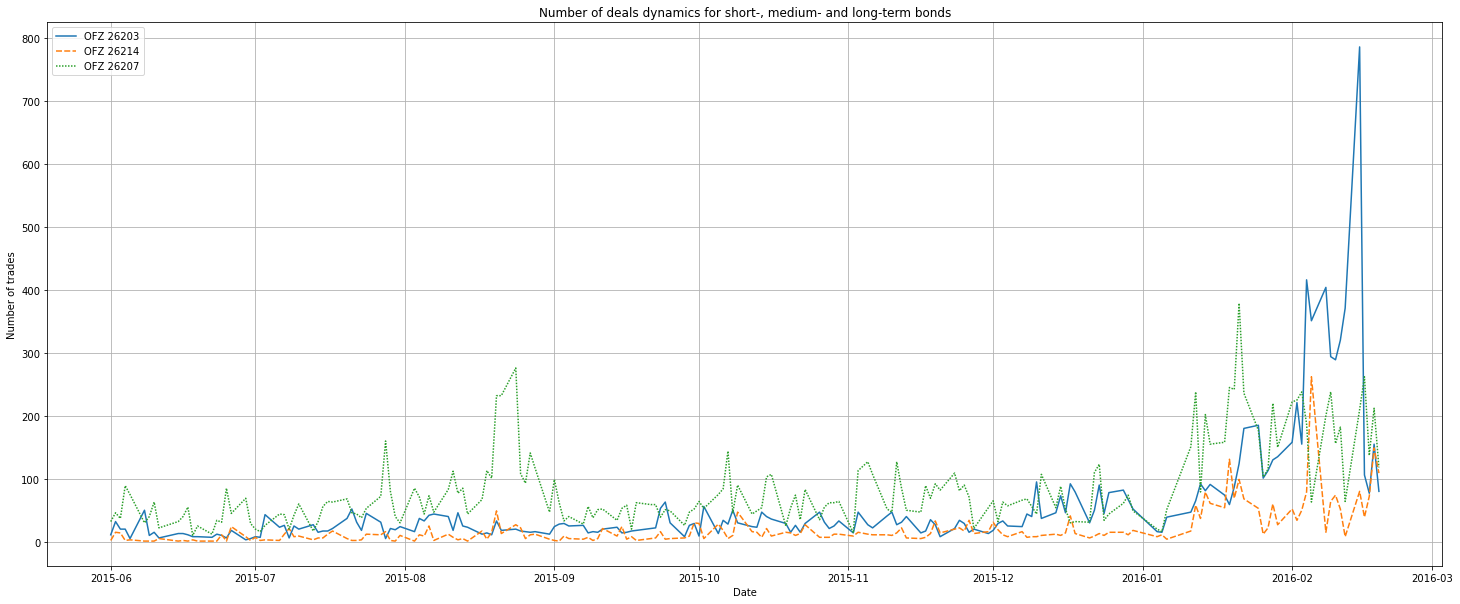

In [31]:
fig, ax = plt.subplots(figsize=(25, 10))
sns.lineplot(data = np.exp(trad_count[['OFZ 26203', 'OFZ 26214', 'OFZ 26207']]))
plt.ylabel('Number of trades')
plt.title('Number of deals dynamics for short-, medium- and long-term bonds')
plt.grid()
plt.savefig(os.path.join(base_path, 'graphs/three_bonds_TC_dynamics.png'), dpi=300)

# Bid-Ask spread

In [73]:
bid_ask = np.log(bid_ask)

In [80]:
ba = mark_low_trading_days(bid_ask)
ba_final = ba.fit_transform(0.0075)
ba_final.head(2)

,SU26214RMFS,SU26215RMFS,SU26216RMFS,SU26203RMFS,SU26204RMFS,SU26205RMFS,SU26206RMFS,SU26207RMFS,SU26208RMFS,SU26209RMFS,...,SU26203RMFS_low_trading_dummy,SU26204RMFS_low_trading_dummy,SU26205RMFS_low_trading_dummy,SU26206RMFS_low_trading_dummy,SU26207RMFS_low_trading_dummy,SU26208RMFS_low_trading_dummy,SU26209RMFS_low_trading_dummy,SU26210RMFS_low_trading_dummy,SU26211RMFS_low_trading_dummy,SU26212RMFS_low_trading_dummy
Date,,,,,,,,,,,,,,,,,,,,,
2015-06-01,4.316955,3.784190,4.574505,3.178054,4.316554,4.553666,3.911823,2.639057,3.911623,4.595019,...,0,0,0,0,0,0,0,0,0,0
2015-06-02,4.007151,5.010502,4.006606,3.366951,3.911423,4.316421,4.317221,3.526361,3.401197,5.940013,...,0,0,0,0,0,0,0,0,0,0


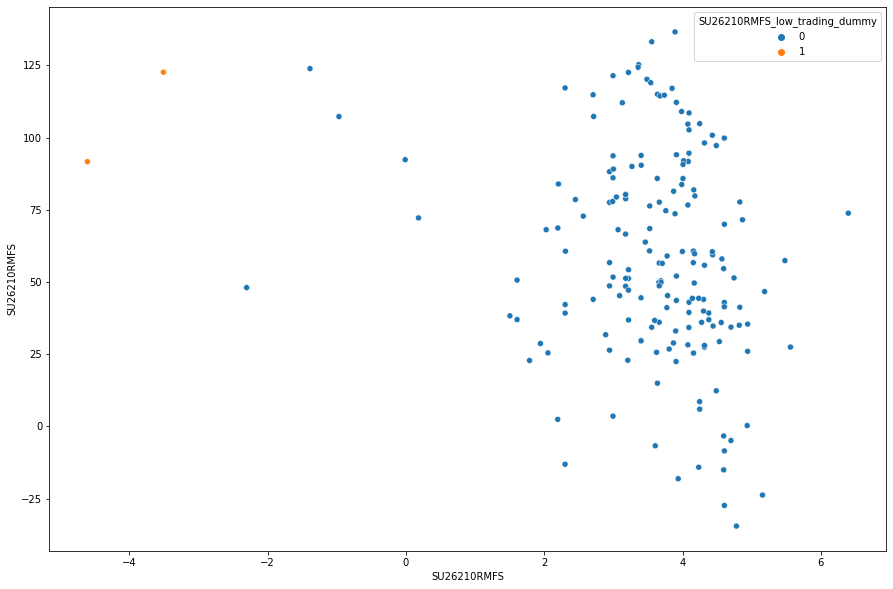

In [83]:
bond = 'SU26210RMFS'

fig, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(x = ba_final[bond], y = rates[bond], hue = ba_final[bond +'_low_trading_dummy'])
plt.show()

In [37]:
ba_final.to_csv(os.path.join(base_path, 'data/metrics_final/BA.csv'))

Text(0.5, 1.0, 'Logarithm of trade count dynamics for all bonds, rolling mean with window = 1-')

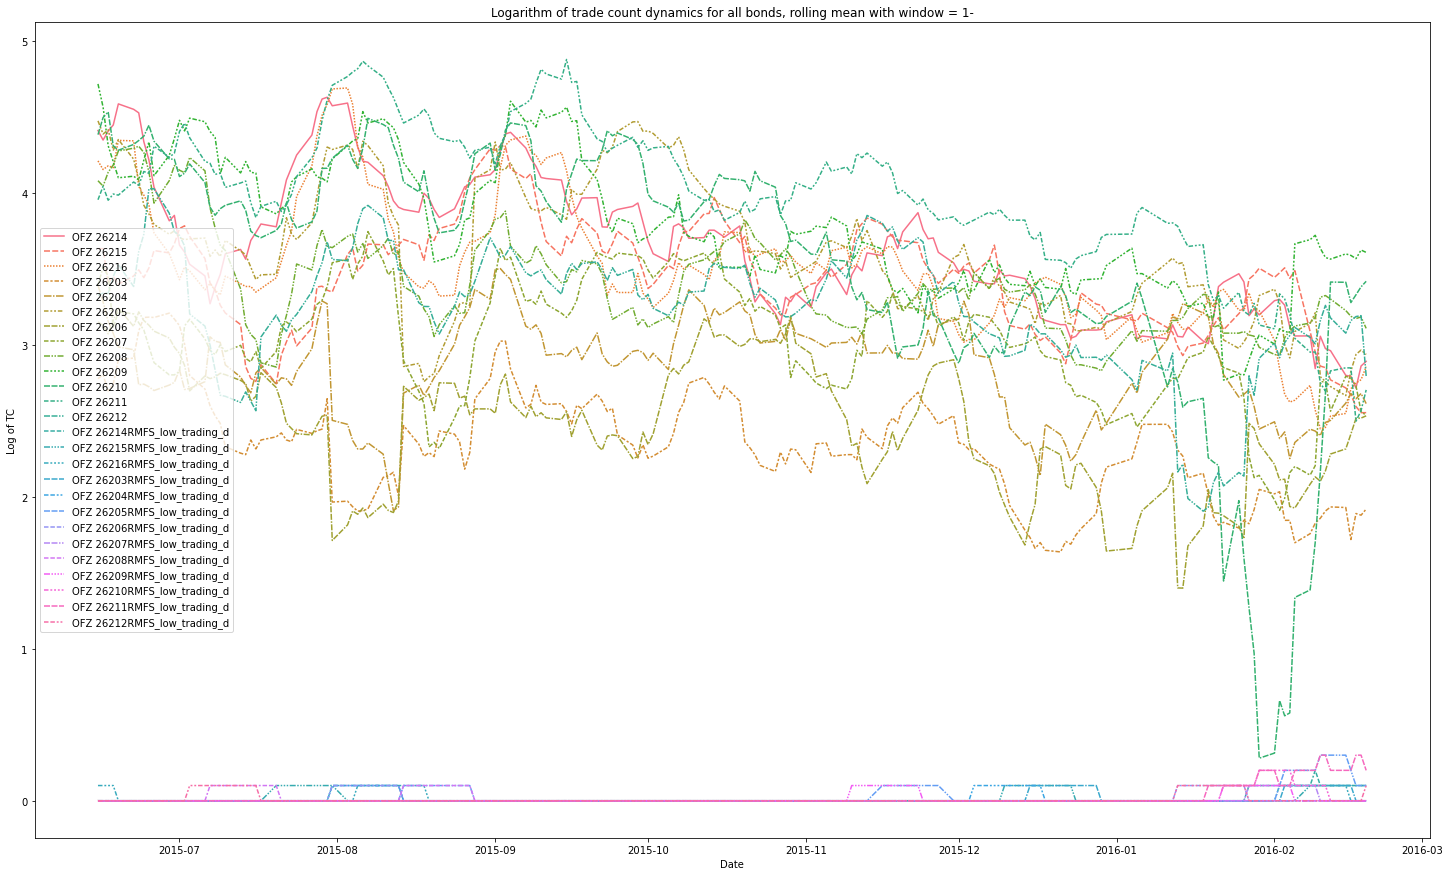

In [78]:
ba_final.columns =  ['OFZ ' + x[2:-4] for x in ba_final.columns]
fig, ax = plt.subplots(figsize=(25, 15))
sns.lineplot(data = ba_final.rolling(window=10).mean())
plt.ylabel('Log of TC')
plt.title('Logarithm of trade count dynamics for all bonds, rolling mean with window = 1-')
#plt.savefig(os.path.join(base_path, 'graphs/log_TC_dynamics.png'), dpi=300)